<a href="https://colab.research.google.com/github/ReginaFierro2000/Artificial-intelligence/blob/main/Project2_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [8]:
from google.colab import drive
drive.mount('/content/drive/')
dataroot = "/content/drive/Mi unidad/celeb"
# Number of workers for dataloader
workers = 4

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 50

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

data_dir = "/content/drive/Mi unidad/celeb"
root=dataroot

Mounted at /content/drive/


In [10]:
from google.colab import drive
drive.mount('/content/gdrive')
# Set path to folder in Google Drive
path = '/content/gdrive/My Drive/celeb'

# Check the contents of the folder
print(os.listdir(path))


Mounted at /content/gdrive
['Train']


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


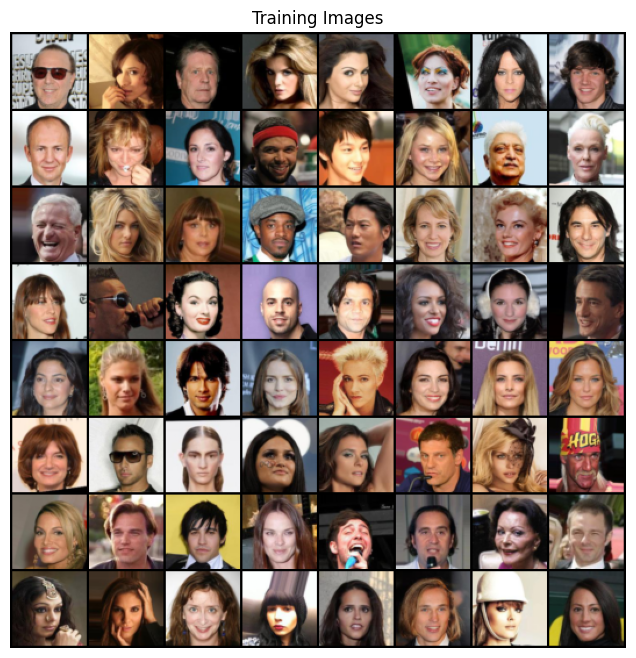

In [11]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(path,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")



In [12]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
     

In [13]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [14]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)
     

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [15]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [16]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [17]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
     

In [18]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label.float())
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label.float())
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label.float())
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        

Starting Training Loop...
[0/50][0/6]	Loss_D: 1.6409	Loss_G: 5.5511	D(x): 0.5702	D(G(z)): 0.5501 / 0.0065
[1/50][0/6]	Loss_D: 0.4260	Loss_G: 8.0488	D(x): 0.8802	D(G(z)): 0.1723 / 0.0006
[2/50][0/6]	Loss_D: 0.0633	Loss_G: 8.7163	D(x): 0.9616	D(G(z)): 0.0177 / 0.0003
[3/50][0/6]	Loss_D: 0.0651	Loss_G: 9.7511	D(x): 0.9576	D(G(z)): 0.0107 / 0.0001
[4/50][0/6]	Loss_D: 0.1122	Loss_G: 19.2193	D(x): 0.9220	D(G(z)): 0.0000 / 0.0000
[5/50][0/6]	Loss_D: 0.0650	Loss_G: 30.8846	D(x): 0.9598	D(G(z)): 0.0000 / 0.0000
[6/50][0/6]	Loss_D: 0.1263	Loss_G: 29.8668	D(x): 0.9299	D(G(z)): 0.0000 / 0.0000
[7/50][0/6]	Loss_D: 0.0226	Loss_G: 19.5177	D(x): 0.9803	D(G(z)): 0.0000 / 0.0000
[8/50][0/6]	Loss_D: 0.0742	Loss_G: 25.3797	D(x): 0.9467	D(G(z)): 0.0000 / 0.0000
[9/50][0/6]	Loss_D: 0.0795	Loss_G: 6.9470	D(x): 0.9521	D(G(z)): 0.0108 / 0.0032
[10/50][0/6]	Loss_D: 0.0108	Loss_G: 33.6305	D(x): 0.9911	D(G(z)): 0.0000 / 0.0000
[11/50][0/6]	Loss_D: 0.1155	Loss_G: 8.6711	D(x): 0.9969	D(G(z)): 0.0807 / 0.0026
[12/50

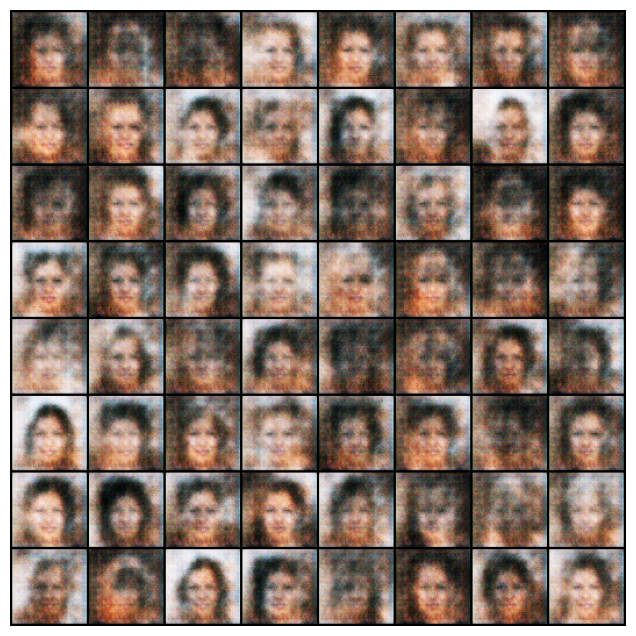

In [19]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [7]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
# file_path is the path where kaggle.json is present in the Google Drive

In [9]:
#%tensorflow_version 1.x
from PIL import Image
import keras  
import matplotlib.pyplot as plt
import os
import pickle

def save_to_disk(txt_path, values):
    if os.path.isfile(txt_path):
        os.remove(txt_path)
    with open(txt_path, "wb") as fp:   
        pickle.dump(values, fp)
    print('Saved {}'.format(txt_path))
    return
def load_from_disk(txt_path):
    with open(txt_path, "rb") as f:
        values =  pickle.load(f)
    print("Loaded {}".format(txt_path))
    return values

def generateImages(generator, epoch, file_path, latent_space_size):
    rows = 3
    columns = 3
    noise = np.random.normal(0, 1, size=(rows*columns, latent_space_size))
    gen_imgs = generator.predict(noise)
    # rescale images
    gen_imgs = 0.5 * (gen_imgs + 1)
    gen_imgs = np.clip(gen_imgs, 0, 1)
    # plot
    fig, axs = plt.subplots(rows, columns, figsize=(15,15))
    cnt = 0
    for i in range(rows):
        for j in range(columns):
            axs[i,j].imshow(np.squeeze(gen_imgs[cnt, :,:,:]))
            axs[i,j].axis('off')
            cnt += 1
    plots_path = os.path.join(file_path,'plots')
    os.makedirs(plots_path, exist_ok=True)
    fig.savefig(os.path.join(plots_path, "epoch{}.png".format(epoch)))
    plt.show()
    plt.close()


def create_conv_layer(input,convolution_type,filters,kernel_size,strides,padding,name,batch_norm=False,dropout=False,activation=True):
        convolution = getattr(keras.layers, convolution_type) # sets Conv2D or Conv2DTranspaose
        conv_layer = convolution(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding = padding,
            name = name
            )
        X = conv_layer(input)
        if batch_norm:
            X = BatchNormalization(momentum=0.9)(X)
        if activation:
            X = LeakyReLU(alpha=0.2)(X)
        return X

def set_trainable(model, value):
    model.trainable = value
    for layer in model.layers:
        layer.trainable = value

In [10]:
import numpy as np
import os
import keras
from keras.layers import Input,Conv2D,Conv2DTranspose,LeakyReLU,Flatten,Dense,BatchNormalization,Reshape,Activation, Multiply,Add, Lambda
from keras.models import load_model, Model
from keras.utils import plot_model
import keras.backend as K
from time import time

class RandomlyWeightedAverage(keras.layers.Layer):
    def __init__(self, batch_size,**kwargs):
        super().__init__(**kwargs)
        self.batch_size = batch_size
    def call(self,inputs):
        alpha = K.random_uniform((self.batch_size, 1, 1, 1))
        return inputs[0]*alpha + inputs[1]*(1-alpha)
    def get_config(self):
        config = {'batch_size': self.batch_size}
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

class WassersteinGAN_GP(object):
    def __init__(self,
                 input_dims,
                 latent_space_size,
                 discriminator_filters,
                 discriminator_kernel_size,
                 discriminator_strides,
                 discriminator_padding,
                 discriminator_loss_weights,
                 generator_init_dense,
                 generator_batch_norm_momentum,
                 generator_filters,
                 generator_kernel_size,
                 generator_strides,
                 generator_padding,
                 optimizer,
                 batch_size
                 ):
        self.input_dims = input_dims
        self.latent_space_size = latent_space_size
        self.discriminator_filters = discriminator_filters
        self.discriminator_kernel_size = discriminator_kernel_size
        self.discriminator_strides = discriminator_strides
        self.discriminator_padding = discriminator_padding
        self.generator_init_dense = generator_init_dense
        self.generator_batch_norm_momentum = generator_batch_norm_momentum
        self.generator_filters = generator_filters
        self.generator_kernel_size = generator_kernel_size
        self.generator_strides = generator_strides
        self.generator_padding = generator_padding
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.discriminator_loss_weights = discriminator_loss_weights
        self._create_model()
    def _create_model(self):
        self._create_discriminator()
        self._create_generator()
        # now that we have generator and discriminator we can make computational graph
        self._create_adversarial_graph()

    def _create_discriminator(self):
        discriminator_input = Input(shape=self.input_dims, name='dicriminator_input')
        X = discriminator_input
        for i in range(len(self.discriminator_filters)):
            X = create_conv_layer(X,
                                        "Conv2D",
                                        self.discriminator_filters[i],
                                        self.discriminator_kernel_size[i],
                                        self.discriminator_strides[i],
                                        self.discriminator_padding[i],
                                        "discriminator_conv"+str(i)
                                        )
        X = Flatten()(X)
        discriminator_output = Dense(units=1, activation=None)(X)
        self.discriminator = Model(inputs=discriminator_input,
                                   outputs=discriminator_output,
                                   name='Discriminator'
                                   )
    def _create_generator(self):
        generator_input = Input(shape=(self.latent_space_size,), name='generator_input')
        X = Dense(np.prod(self.generator_init_dense))(generator_input)
        X = BatchNormalization(momentum = self.generator_batch_norm_momentum)(X)    
        X = LeakyReLU(alpha=0.2)(X)
        X = Reshape(self.generator_init_dense)(X)
        for i in range(len(self.generator_filters)):
            is_not_last_layer = i < len(self.generator_filters)-1
            X = create_conv_layer(X,
                                  "Conv2DTranspose",
                                  self.generator_filters[i],
                                  self.generator_kernel_size[i],
                                  self.generator_strides[i],
                                  self.generator_padding[i],
                                  "generator_conv"+str(i),
                                  batch_norm=is_not_last_layer,
                                  activation=is_not_last_layer
                                  )
        generator_output = Activation('tanh')(X)
        self.generator = Model(inputs=generator_input,
                               outputs=generator_output,
                               name='Generator'
                               )
    def _create_adversarial_graph(self):
        #--------------------------------------------
        # discriminator (critic) computational graph
        #--------------------------------------------
        real_img = Input(shape=self.input_dims)
        latent_space = Input(shape=(self.latent_space_size,))
        fake_img = self.generator(latent_space)
        # interpolate real and fake images
        self.interpolated_img = RandomlyWeightedAverage(self.batch_size)([real_img, fake_img])
        # pass it through discriminator
        real_critic = self.discriminator(real_img)
        fake_critic = self.discriminator(fake_img)
        interpolated_critic = self.discriminator(self.interpolated_img)
        set_trainable(self.generator, False) # freeze weights for generator while training discriminator
        self.discriminator_model = Model(inputs=[real_img, latent_space],
                                         outputs=[real_critic, fake_critic, interpolated_critic],
                                         name='Discriminator_model'
                                         )
        self.discriminator_model.compile(
            loss=[self.Wasserstein_loss, self.Wasserstein_loss, self.GP_loss],
            optimizer=self.optimizer,
            loss_weights=self.discriminator_loss_weights
            )
        #--------------------------------------------
        # generator computational graph
        #--------------------------------------------
        gen_input = Input(shape=(self.latent_space_size,))
        gen_image = self.generator(gen_input)
        gen_output = self.discriminator(gen_image)
        set_trainable(self.generator,True)
        set_trainable(self.discriminator, False)
        self.generator_model = Model(inputs=gen_input, outputs=gen_output,name='Generator_model')
        self.generator_model.compile(
            loss=self.Wasserstein_loss,
            optimizer=self.optimizer
        )
        set_trainable(self.discriminator, True)
    def Wasserstein_loss(self, y_true, y_pred):
        return -K.mean(y_true*y_pred)
    def GP_loss(self,y_true,y_pred):
        gradients = K.gradients(y_pred, self.interpolated_img)[0]
        gradients_sqr = K.square(gradients)
        gradients_norm = K.sqrt(K.sum(gradients_sqr, axis=np.arange(1, len(gradients_sqr.shape))))
        return K.mean(K.square(1-gradients_norm))
    def _train_discriminator(self, images_train):
        real_labels = np.ones((self.batch_size,1), dtype='float32')
        fake_labels = -np.ones((self.batch_size,1), dtype='float32')
        dummy_labels = np.zeros((self.batch_size,1), dtype='float32') # this wont be in any calculation

        real_imgs = next(images_train)[0]
        if real_imgs.shape[0] != self.batch_size:
            real_imgs = next(images_train)[0]
        noise = np.random.normal(0,1,size=(self.batch_size,self.latent_space_size))

        d_loss = self.discriminator_model.train_on_batch(
            [real_imgs, noise],
            [real_labels, fake_labels, dummy_labels]
            )
        return d_loss
    def _train_generator(self):
        labels = np.ones((self.batch_size,1), dtype='float32')
        noise = np.random.normal(0,1,size=(self.batch_size,self.latent_space_size))
        g_loss = self.generator_model.train_on_batch(noise, labels)
        return g_loss
    def train(self,images_train,epochs,discriminator_iterations,steps_per_epoch,file_path,initial_epoch=0,continue_training=False):
        if continue_training:
            checkpoint_path = os.path.join(file_path,'trained')
            self.load_weights(checkpoint_path)
            g_losses = load_from_disk(os.path.join(checkpoint_path,'gLosses.txt'))
            d_losses = load_from_disk(os.path.join(checkpoint_path,'dLosses.txt'))
        else:
            d_losses = []
            g_losses = []
        epoch = initial_epoch
        steps = 0
        print('Training has started!')
        tic = time()
        while epoch < epochs:
            # train discriminator several times
            for i in range(discriminator_iterations):
                d_loss = self._train_discriminator(images_train)
                print("\r epoch {}: step {}/{}".format(epoch,steps,steps_per_epoch),end='')
                steps += 1
            # train generator
            g_loss = self._train_generator()
            d_losses.append(d_loss)
            g_losses.append(g_loss)
            # if epoch ended
            if steps >= steps_per_epoch:
                toc = time() 
                print('')
                print(f"epoch {epoch} --->" +
                      f" D_losses: [R:{d_loss[0]:.2f}, F:{d_loss[1]:.2f}, GP:{d_loss[2]:.2f}]" + 
                      f" G_loss: {g_loss:.2f}" + 
                      f", elapsed time {(toc-tic)/60:.2f} min"
                )          
                epoch += 1
                generateImages(self.generator, epoch, file_path,self.latent_space_size)
            # checkpoint every 5 epochs
            if (epoch % 5 == 0) and (epoch != 0) and (steps >= steps_per_epoch): 
                checkpoint_path = os.path.join(file_path,'trained')
                os.makedirs(checkpoint_path, exist_ok=True)
                save_to_disk(os.path.join(checkpoint_path,'gLosses.txt'),g_losses)
                save_to_disk(os.path.join(checkpoint_path,'dLosses.txt'),d_losses)
                self.save_weights(checkpoint_path)
            if steps >= steps_per_epoch:
                steps=0
                tic = time()
        return d_losses, g_losses

    def save_weights(self, checkpoint_path):
        self.generator_model.save_weights(os.path.join(checkpoint_path,'generator_model_weights.h5'))
        self.discriminator_model.save_weights(os.path.join(checkpoint_path,'discriminator_model_weights.h5'))
        self.generator.save_weights(os.path.join(checkpoint_path,'generator_weights.h5'))
        self.discriminator.save_weights(os.path.join(checkpoint_path,'discriminator_weights.h5'))
        # save optimizer weights
        save_to_disk(os.path.join(checkpoint_path,'d_optimizer_weights.txt'),
                     self.discriminator_model.optimizer.get_weights()
                     )
        save_to_disk(os.path.join(checkpoint_path,'g_optimizer_weights.txt'),
                     self.generator_model.optimizer.get_weights()
                     )
        print('Weights are saved!')
    def load_weights(self, checkpoint_path):
        self.generator_model.load_weights(os.path.join(checkpoint_path,'generator_model_weights.h5'))
        self.discriminator_model.load_weights(os.path.join(checkpoint_path,'discriminator_model_weights.h5'))
        self.generator.load_weights(os.path.join(checkpoint_path,'generator_weights.h5'))
        self.discriminator.load_weights(os.path.join(checkpoint_path,'discriminator_weights.h5'))
        # load optimizer weights
        path = os.path.join(checkpoint_path,'d_optimizer_weights.txt')
        self.discriminator_model.optimizer.weights = load_from_disk(path)
        path = os.path.join(checkpoint_path,'g_optimizer_weights.txt')
        self.generator_model.optimizer.weights = load_from_disk(path)
        print('Pretrained weights are loaded!')
     

In [11]:
from keras.optimizers import Adam
OPTIMIZER=Adam(lr=0.0002)
INPUT_DIMS = (64,64,3)
BATCH_SIZE = 64
LATENT_SPACE_SIZE=100
FILE_PATH = '/content/drive/Mi unidad/celeb'

WGAN_GP = WassersteinGAN_GP(
        input_dims=INPUT_DIMS,
        latent_space_size=LATENT_SPACE_SIZE,
        discriminator_filters=[64,128,256,512],
        discriminator_kernel_size=[5,5,5,5],
        discriminator_strides=[2,2,2,2],
        discriminator_padding=["same","same","same","same"],
        discriminator_loss_weights=[1,1,10],
        generator_init_dense=(4, 4, 512),
        generator_batch_norm_momentum=0.9,
        generator_filters=[256,128,64,3], 
        generator_kernel_size=[5,5,5,5],
        generator_strides=[2,2,2,2],
        generator_padding=["same","same","same","same"],
        optimizer=OPTIMIZER,
        batch_size=BATCH_SIZE
        )
print("Discriminator and generator summary:")
WGAN_GP.discriminator.summary()
WGAN_GP.generator.summary()
     

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Discriminator and generator summary:
Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dicriminator_input (InputLa  [(None, 64, 64, 3)]      0         
 yer)                                                            
                                                                 
 discriminator_conv0 (Conv2D  (None, 32, 32, 64)       4864      
 )                                                               
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 discriminator_conv1 (Conv2D  (None, 16, 16, 128)      204928    
 )                                                               
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                

In [12]:
from keras.optimizers import Adam
OPTIMIZER=Adam(lr=0.0002)
INPUT_DIMS = (128,128,3)
BATCH_SIZE = 64
LATENT_SPACE_SIZE=200
FILE_PATH = '/content/drive/Mi unidad/celeb'

WGAN_GP = WassersteinGAN_GP(
        input_dims=INPUT_DIMS,
        latent_space_size=LATENT_SPACE_SIZE,
        discriminator_filters=[64,128,256,512],
        discriminator_kernel_size=[3,3,3,3],
        discriminator_strides=[2,2,2,2],
        discriminator_padding=["same","same","same","same"],
        discriminator_loss_weights=[1,1,10],
        generator_init_dense=(8, 8, 512),
        generator_batch_norm_momentum=0.9,
        generator_filters=[256,128,64,3], 
        generator_kernel_size=[3,3,3,3],
        generator_strides=[2,2,2,2],
        generator_padding=["same","same","same","same"],
        optimizer=OPTIMIZER,
        batch_size=BATCH_SIZE
        )
print("Discriminator_model and generator_model summary:")
WGAN_GP.generator_model.summary()
WGAN_GP.generator.summary()
     

Discriminator_model and generator_model summary:
Model: "Generator_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 200)]             0         
                                                                 
 Generator (Functional)      (None, 128, 128, 3)       8269699   
                                                                 
 Discriminator (Functional)  (None, 1)                 1583745   
                                                                 
Total params: 9,853,444
Trainable params: 9,787,012
Non-trainable params: 66,432
_________________________________________________________________
Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator_input (InputLayer  [(None, 200)]            0         
 )                                

In [32]:
from keras.preprocessing.image import ImageDataGenerator
import os
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

EPOCHS = 60
INITIAL_EPOCH = 30
DISCRIMINATOR_ITERATIONS = 5

# path to the FOLDER contatining images #img_align_celeba
DATA_PATH = os.path.join(os.getcwd(), "img_align_celeba") 
file_names = []
for file_name in os.listdir(os.path.join(DATA_PATH,"img_align_celeba")):
    file_names.append(file_name)
DATASET_SIZE = len(file_names)

# create image generator and data flow
data_generator = ImageDataGenerator(preprocessing_function=lambda x: (x.astype('float32') - 127.5) / 127.5)
data_flow = data_generator.flow_from_directory(
        DATA_PATH,
        target_size = INPUT_DIMS[:2],
        batch_size = BATCH_SIZE,
        shuffle = True,
        class_mode = 'input',
        subset = "training"
        )

# train the VAE with fit_generator
d_losses, g_losses = WGAN_GP.train(
        images_train=data_flow,
        epochs=EPOCHS,
        discriminator_iterations=DISCRIMINATOR_ITERATIONS,
        steps_per_epoch=DATASET_SIZE // BATCH_SIZE,
        file_path=FILE_PATH,
        initial_epoch=INITIAL_EPOCH,
        continue_training=True
        )

FileNotFoundError: ignored